<a href="https://colab.research.google.com/github/Yamm23/Learning-Macine-Learning/blob/main/mBertQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Data Head:
  Building Type  Square Footage  Number of Occupants  Appliances Used  \
0   Residential            7063                   76               10   
1    Commercial           44372                   66               45   
2    Industrial           19255                   37               17   
3   Residential           13265                   14               41   
4    Commercial           13375                   26               18   

   Average Temperature Day of Week  Energy Consumption  
0                29.84     Weekday             2713.95  
1                16.72     Weekday             5744.99  
2                14.30     Weekend             4101.24  
3                32.82     Weekday             3009.14  
4                11.92     Weekday             3279.17  

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------            

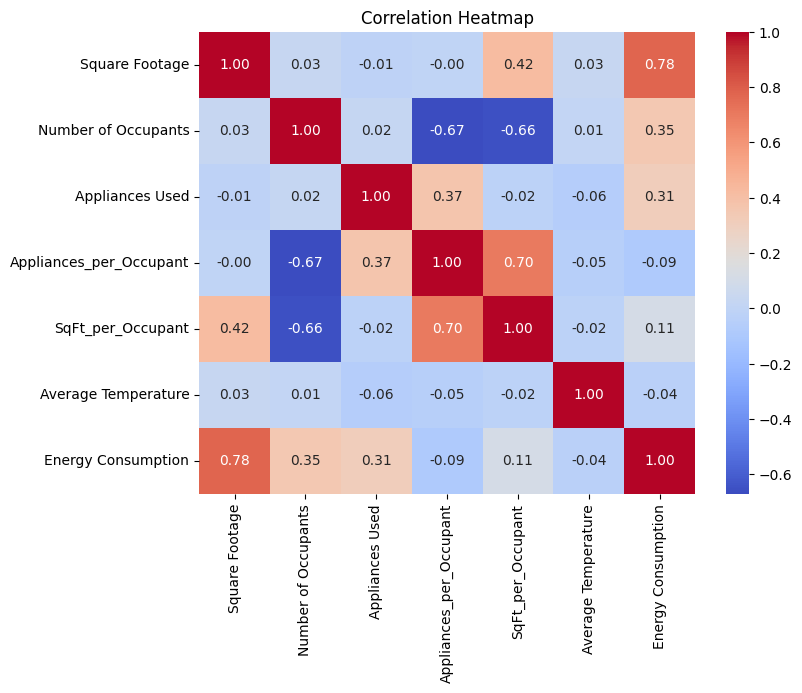

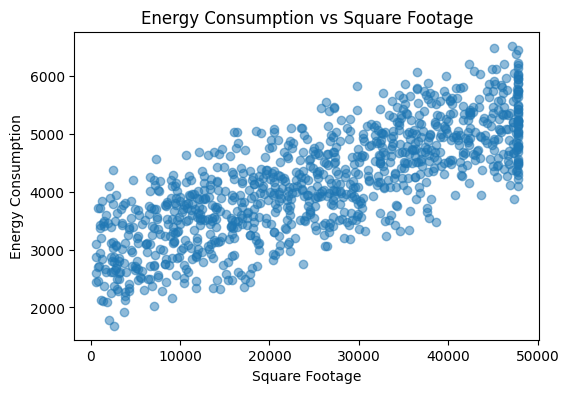

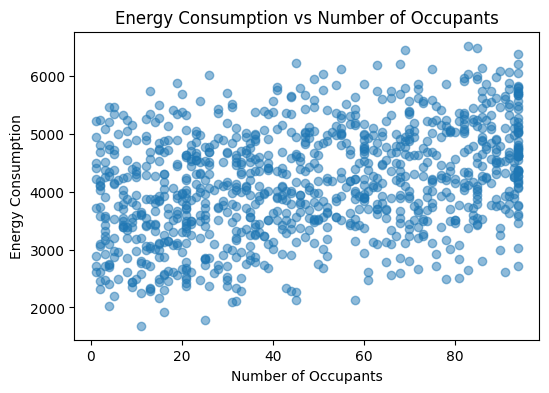

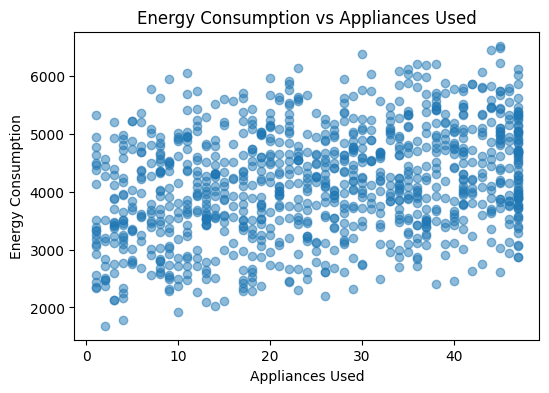

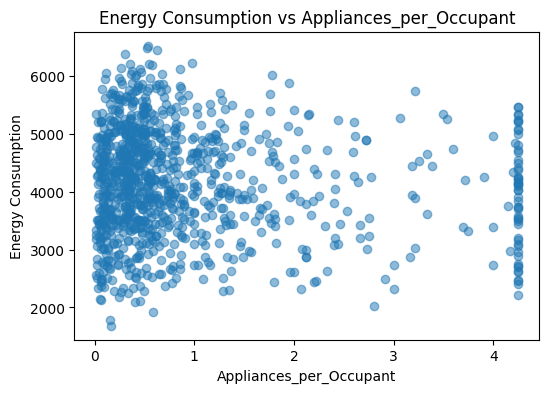

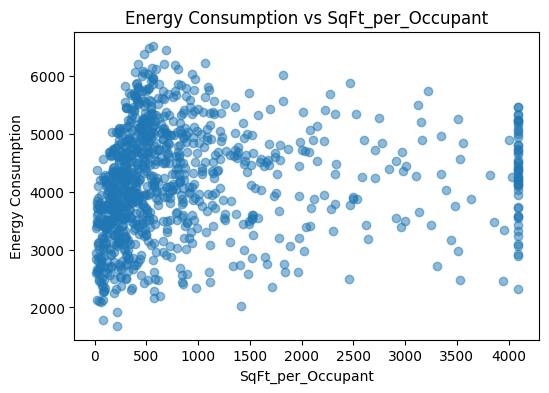

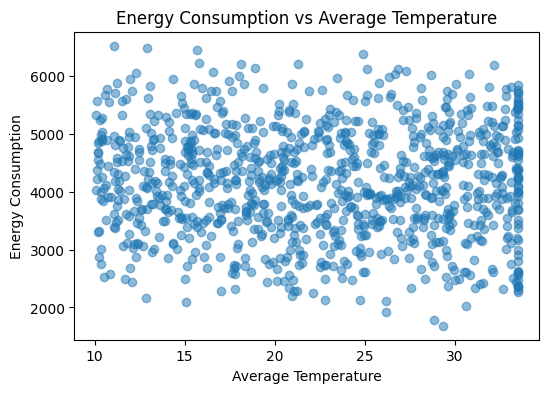

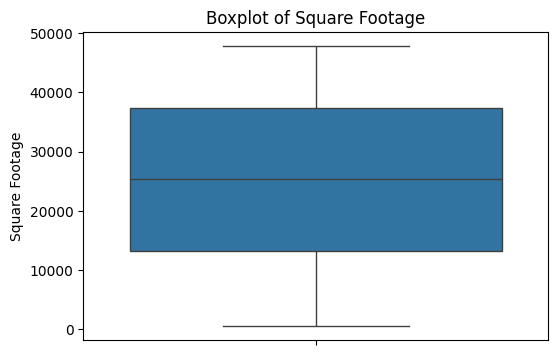

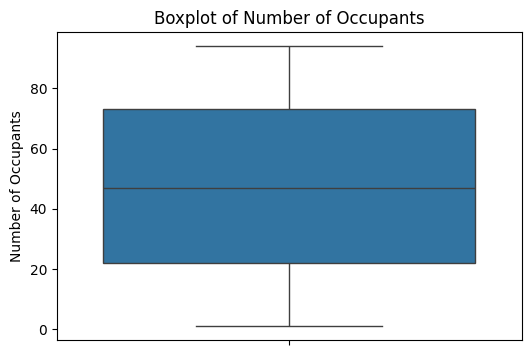

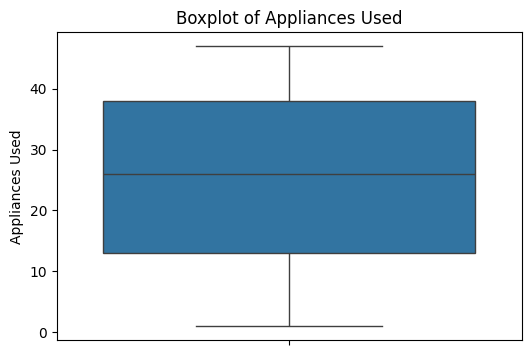

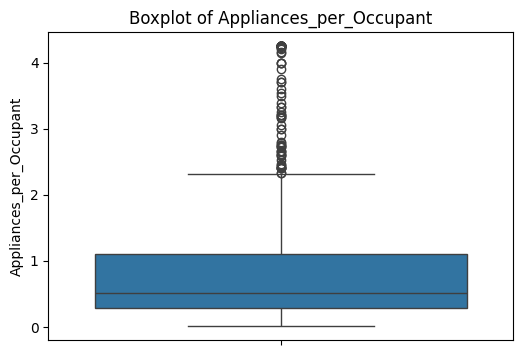

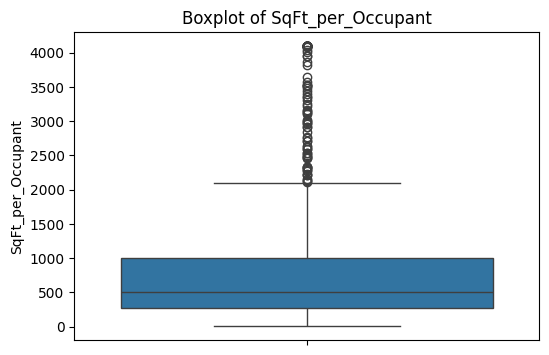

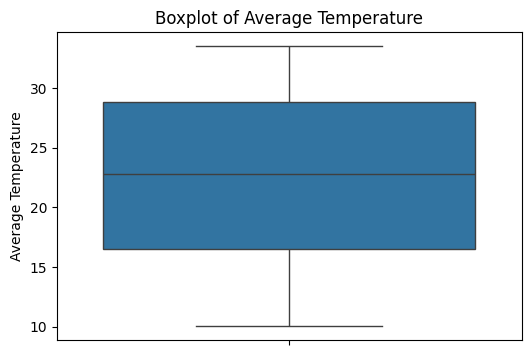


Linear Regression Performance:
MSE: 186.981716060936
R² Score: 0.9997275210101476
MAE: 9.273464418855966
Linear Regression CV RMSE: 16.804863179892063

Random Forest Performance:
MSE: 15805.152387933887
R² Score: 0.9769679514775421
MAE: 100.82145600000018
Random Forest CV RMSE: 134.9487529813239


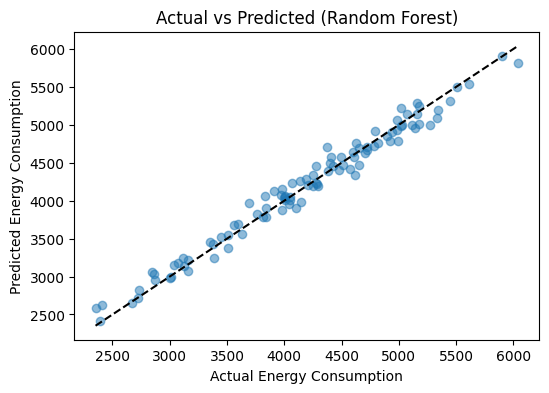

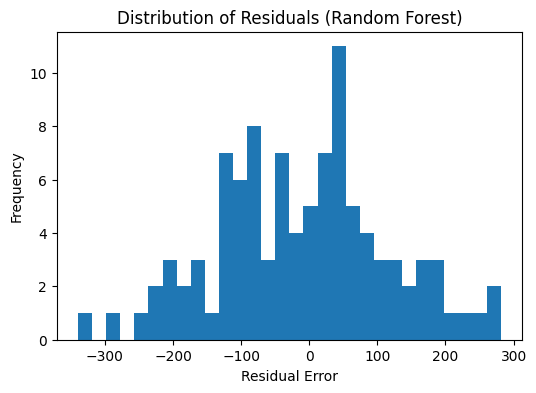

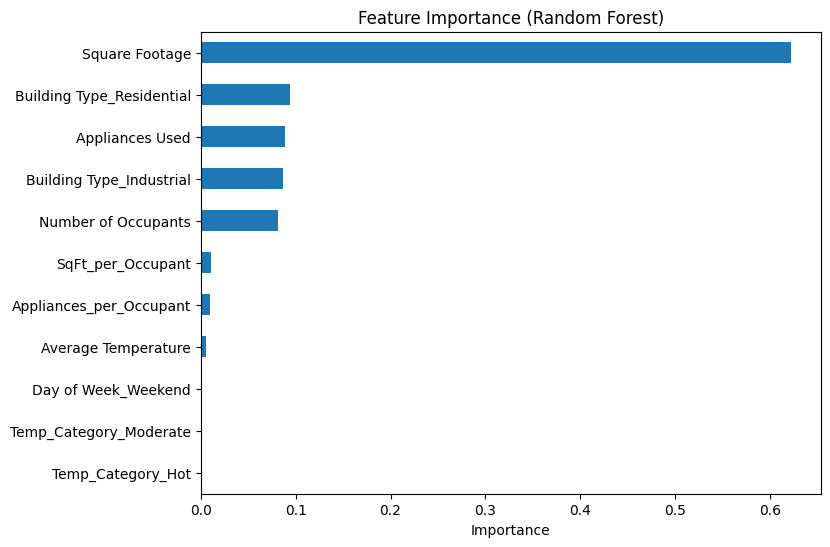

Model saved as 'energy_model_rf.pkl'


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import joblib

# Load data
df_train = pd.read_csv('/content/drive/MyDrive/LearningAI_CSV/EnergyConsumptionDataset/train_energy_data.csv')
df_test = pd.read_csv('/content/drive/MyDrive/LearningAI_CSV/EnergyConsumptionDataset/test_energy_data.csv')

# EDA: Inspect data
print("Training Data Head:")
print(df_train.head())
print("\nTraining Data Info:")
print(df_train.info())
print("\nTraining Data Description:")
print(df_train.describe())
print("\nMissing Values:")
print(df_train.isnull().sum())

# Check unique values in categorical columns
building_types = df_train['Building Type'].unique()
days = df_train['Day of Week'].unique()
print(f'\nBuilding Types: {building_types}')
print(f'Days of Week: {days}')

# Feature Engineering
# 1. Interaction and derived features
df_train['Appliances_per_Occupant'] = df_train['Appliances Used'] / (df_train['Number of Occupants'] +
1)  # Avoid division by zero
df_test['Appliances_per_Occupant'] = df_test['Appliances Used'] / (df_test['Number of Occupants'] + 1)

df_train['SqFt_per_Occupant'] = df_train['Square Footage'] / (df_train['Number of Occupants'] + 1)
df_test['SqFt_per_Occupant'] = df_test['Square Footage'] / (df_test['Number of Occupants'] + 1)

# 2. Bin Average Temperature to capture non-linear effects
bins = [-float('inf'), 15, 25, float('inf')]
labels = ['Cold', 'Moderate', 'Hot']
df_train['Temp_Category'] = pd.cut(df_train['Average Temperature'], bins=bins, labels=labels)
df_test['Temp_Category'] = pd.cut(df_test['Average Temperature'], bins=bins, labels=labels)

# 3. Handle outliers by capping at 95th percentile
numerical_cols = ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Appliances_per_Occupant', 'SqFt_per_Occupant', 'Average Temperature']
for col in numerical_cols:
    upper_limit = df_train[col].quantile(0.95)
    df_train[col] = df_train[col].clip(upper=upper_limit)
    df_test[col] = df_test[col].clip(upper=upper_limit)

# Correlation heatmap (before encoding categorical variables)
plt.figure(figsize=(8, 6))
corr = df_train[numerical_cols + ['Energy Consumption']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Visualize relationships with target
for column in numerical_cols:
    plt.figure(figsize=(6, 4))
    plt.scatter(df_train[column], df_train['Energy Consumption'], alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('Energy Consumption')
    plt.title(f'Energy Consumption vs {column}')
    plt.show()

# Visualize outliers
for column in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_train[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

# Define features and target
X_train = df_train.drop(['Energy Consumption'], axis=1)
y_train = df_train['Energy Consumption']
X_test = df_test.drop(['Energy Consumption'], axis=1)
y_test = df_test['Energy Consumption']

# Preprocessing pipeline
categorical_cols = ['Building Type', 'Day of Week', 'Temp_Category']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Model pipelines
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_estimators=100))
])

# Fit and evaluate Linear Regression
pipeline_lr.fit(X_train, y_train)
prediction_lr = pipeline_lr.predict(X_test)

print('\nLinear Regression Performance:')
print('MSE:', mean_squared_error(y_test, prediction_lr))
print('R² Score:', r2_score(y_test, prediction_lr))
print('MAE:', mean_absolute_error(y_test, prediction_lr))

# Cross-validation for Linear Regression
cv_scores_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print('Linear Regression CV RMSE:', np.sqrt(-cv_scores_lr.mean()))

# Fit and evaluate Random Forest
pipeline_rf.fit(X_train, y_train)
prediction_rf = pipeline_rf.predict(X_test)

print('\nRandom Forest Performance:')
print('MSE:', mean_squared_error(y_test, prediction_rf))
print('R² Score:', r2_score(y_test, prediction_rf))
print('MAE:', mean_absolute_error(y_test, prediction_rf))

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print('Random Forest CV RMSE:', np.sqrt(-cv_scores_rf.mean()))

# Visualize Actual vs Predicted (Random Forest)
plt.figure(figsize=(6, 4))
plt.scatter(y_test, prediction_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Diagonal line
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('Actual vs Predicted (Random Forest)')
plt.show()

# Residuals for Random Forest
plt.figure(figsize=(6, 4))
residuals_rf = y_test - prediction_rf
plt.hist(residuals_rf, bins=30)
plt.title('Distribution of Residuals (Random Forest)')
plt.xlabel('Residual Error')
plt.ylabel('Frequency')
plt.show()

# Feature Importance (Random Forest)
feature_names = numerical_cols + list(pipeline_rf.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .get_feature_names_out(categorical_cols))
importances = pipeline_rf.named_steps['model'].feature_importances_
feature_importance = pd.Series(importances, index=feature_names).sort_values()

plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.show()

# Save the better-performing model (Random Forest)
joblib.dump(pipeline_rf, 'energy_model_rf.pkl')
print("Model saved as 'energy_model_rf.pkl'")